In [4]:
import datetime
import pickle

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [5]:
with open('notMNIST-all.pickle', 'rb+') as f:
    save = pickle.load(f)

data = save['data']
labels = save['labels']

del save  # hint to help gc free up memory
print(data.shape, labels.shape)

def reformat_for_conv(data, labels):
    data = data.reshape((-1, 28, 28, 1)).astype(np.float32)
    labels = (np.arange(10) == labels[:, None]).astype(np.float32)
    return data, labels

data, labels = reformat_for_conv(data, labels)

def data_batcher(data, batch_size, loop_around=True, start_batch=0):
    internal_step = start_batch
    
    while True:        
        offset = internal_step * batch_size
        
        if offset+batch_size > data.shape[0]:
            if not loop_around:
                return
            else:
                internal_step = start_batch
                continue

        internal_step += 1
        
        #print(offset, offset+batch_size)
        yield data[offset:(offset + batch_size)]

(220000, 28, 28) (220000,)


In [10]:
batch_size = 64
G_input_noise_size = 7
G_input_noise_depth = 4 # when chaging this remember to also adjust the tconv filter sizes in G

graph = tf.Graph()

with graph.as_default():

    # D input
    tf_real_data = tf.placeholder(tf.float32, shape=(batch_size//2, 28, 28, 1), name='tf_real_data')
    
    # G input
    # random noise input is generated on the GPU  
    
    def D(data):
        with tf.variable_scope("GAN/Discriminator", reuse=tf.AUTO_REUSE):
            conv0 = tf.layers.conv2d(data, 10, (5, 5), strides=(2, 2), padding='same', activation=tf.nn.leaky_relu, name='conv0')
            conv1 = tf.layers.conv2d(conv0, 10, (3, 3), strides=(2, 2), padding='same', activation=tf.nn.leaky_relu, name='conv1')
            conv2 = tf.layers.conv2d(conv1, 12, (3, 3), strides=(2, 2), padding='same', activation=tf.nn.leaky_relu, name='conv2')
            
            flattened = tf.layers.flatten(conv2)

            dense0 = tf.layers.dense(flattened, 45, activation=tf.nn.leaky_relu, name='dense0')
            dense1 = tf.layers.dense(dense0, 1, name='dense1')

        return dense1
    
    
    def G(z):
        with tf.variable_scope("GAN/Generator", reuse=tf.AUTO_REUSE):
            dense0 = tf.layers.dense(z, 250, activation=tf.nn.leaky_relu, name='dense0')
            dense1 = tf.layers.dense(dense0, 294, activation=tf.nn.leaky_relu, name='dense1')
            
            reshaped = tf.reshape(dense1, shape=(-1, 7, 7, 6))
            
            tconv0 = tf.layers.conv2d_transpose(reshaped, 4, (4, 4), strides=(2, 2), padding='same', name='tconv0')
            tconv1 = tf.layers.conv2d_transpose(tconv0, 1, (2, 2), strides=(2, 2), padding='same', name='tconv1')
            
            
        return tconv1

    
    # -- train D --
    
    z_half = tf.truncated_normal((batch_size//2, G_input_noise_size*G_input_noise_size*G_input_noise_depth))
    G_samples = G(z_half)
    
    D_prediction_on_real_data = D(tf_real_data)
    D_prediction_on_fake_data = D(G_samples)
    
    D_accuracy_on_fake = tf.metrics.accuracy(labels=tf.ones_like(D_prediction_on_real_data), predictions=tf.round(D_prediction_on_real_data))
    D_accuracy_on_real = tf.metrics.accuracy(labels=tf.zeros_like(D_prediction_on_fake_data), predictions=tf.round(D_prediction_on_fake_data))
    
    
    with tf.name_scope('D_loss'):
        D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_prediction_on_real_data, labels=tf.ones_like(D_prediction_on_real_data)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=D_prediction_on_fake_data, labels=tf.zeros_like(D_prediction_on_fake_data)))

    D_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Discriminator")
        
    #D_global_step = tf.Variable(0, trainable=False)
    #D_momentum = tf.train.exponential_decay(0.99, D_global_step, 1000, 0.99, staircase=False)
    #D_optimizer = tf.train.MomentumOptimizer(learning_rate=0.0001, momentum=D_momentum, use_nesterov=False).minimize(D_loss, var_list=D_vars, global_step=D_global_step)
    #D_optimizer = tf.train.RMSPropOptimizer(learning_rate=0.005).minimize(D_loss, var_list=D_vars)
    D_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(D_loss, var_list=D_vars)
    

    # -------------
    
    
    # -- train G --

    z = tf.truncated_normal((batch_size, G_input_noise_size*G_input_noise_size*G_input_noise_depth))
    gen_images = G(z)
    
    with tf.name_scope('G_loss'):
        # 1 real, 0 fake 
        D_judgement = D(gen_images)
        G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_judgement, labels=tf.ones_like(D_judgement)))
        
    G_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Generator")

    #G_global_step = tf.Variable(0, trainable=False)
    #G_momentum = tf.train.exponential_decay(0.99, G_global_step, 1000, 0.99, staircase=False)
    #G_optimizer = tf.train.MomentumOptimizer(learning_rate=0.0001, momentum=G_momentum, use_nesterov=False).minimize(G_loss, var_list=G_vars, global_step=G_global_step)
    #G_optimizer = tf.train.RMSPropOptimizer(learning_rate=0.005).minimize(G_loss, var_list=G_vars)
    G_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(G_loss, var_list=G_vars)
    
    
    # -------------
    
    """
        #tf.summary.scalar('train_acc', train_acc[1])"""

Initialized.


step:0 D_l:1.420432 G_l:0.694661


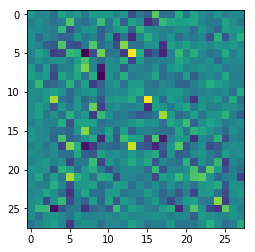

step:100 D_l:1.340577 G_l:0.738358


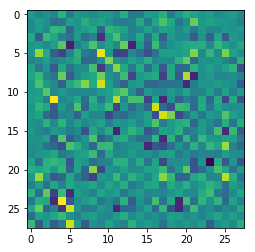

step:200 D_l:1.173574 G_l:0.933519


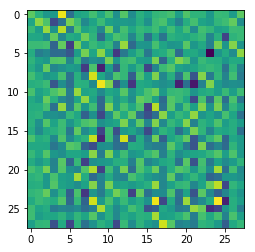

step:300 D_l:0.760933 G_l:0.961442


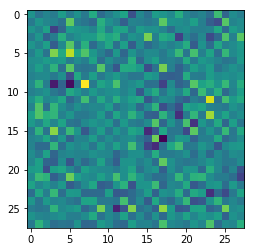

step:400 D_l:0.414713 G_l:2.234972


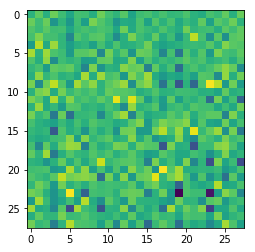

step:500 D_l:1.576381 G_l:1.350992


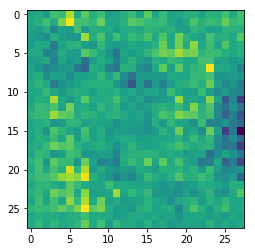

step:600 D_l:0.765465 G_l:1.753089


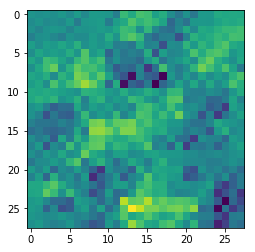

step:700 D_l:0.757993 G_l:1.643031


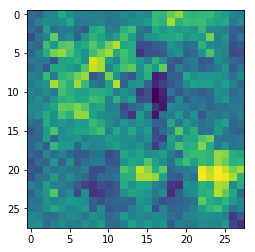

step:800 D_l:0.944840 G_l:1.219689


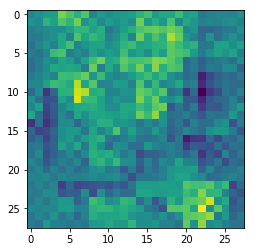

step:900 D_l:0.955012 G_l:1.818506


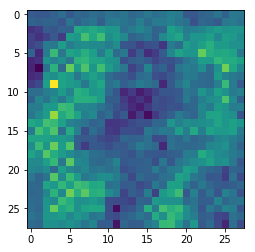

step:1000 D_l:0.721633 G_l:1.565663


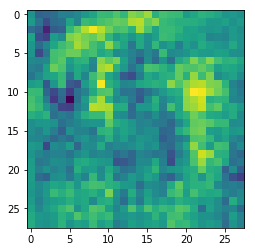

step:1100 D_l:1.225556 G_l:2.512409


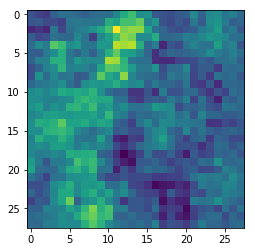

step:1200 D_l:0.815700 G_l:1.965807


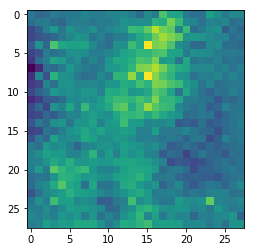

step:1300 D_l:0.711304 G_l:1.328318


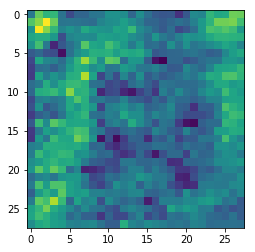

step:1400 D_l:0.524138 G_l:1.642410


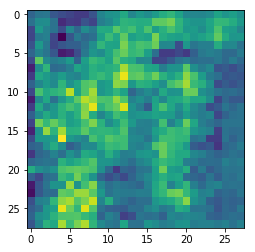

step:1500 D_l:0.489616 G_l:1.873020


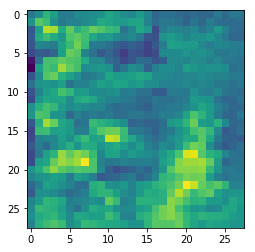

step:1600 D_l:0.540513 G_l:2.577754


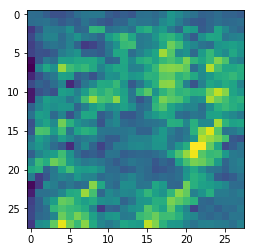

step:1700 D_l:0.504705 G_l:2.139584


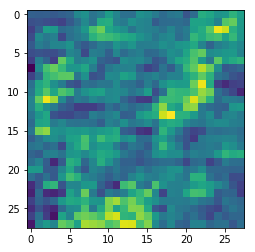

step:1800 D_l:0.432714 G_l:2.117300


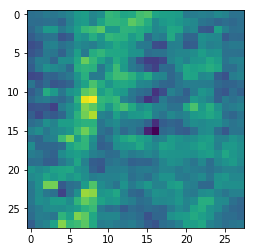

step:1900 D_l:0.562113 G_l:2.908873


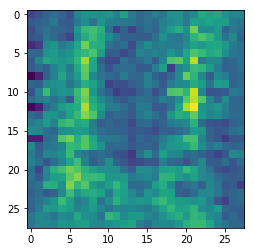

step:2000 D_l:0.413370 G_l:2.629509


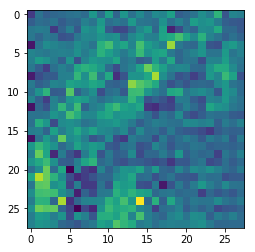

step:2100 D_l:0.296384 G_l:2.294546


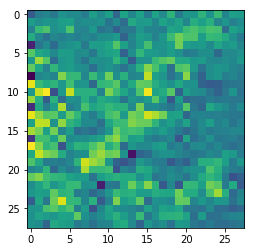

step:2200 D_l:0.217428 G_l:3.042415


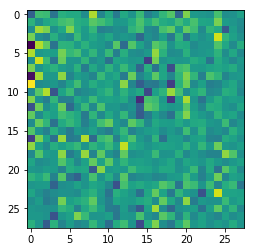

step:2300 D_l:0.016304 G_l:4.534459


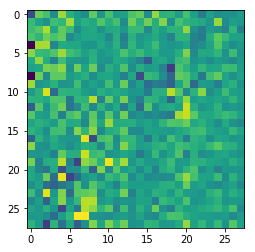

step:2400 D_l:0.066614 G_l:4.579000


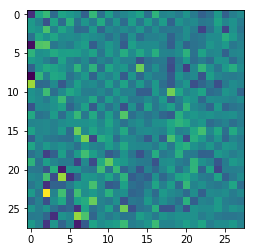

step:2500 D_l:0.031144 G_l:4.146645


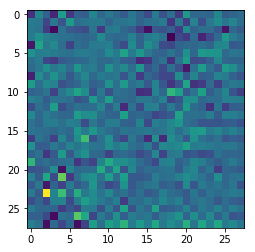

step:2600 D_l:0.446972 G_l:2.463486


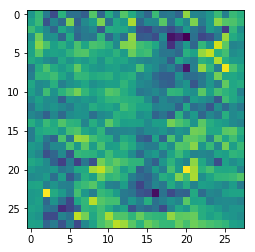

step:2700 D_l:0.440257 G_l:1.783085


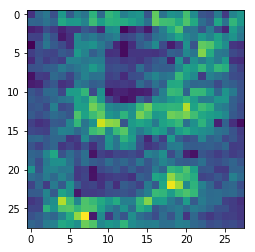

step:2800 D_l:0.181125 G_l:3.482637


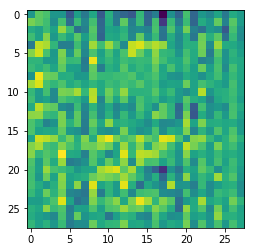

step:2900 D_l:0.476327 G_l:4.474487


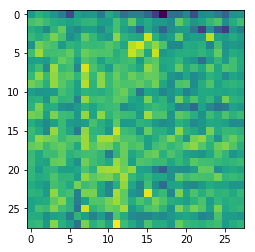

step:3000 D_l:0.057651 G_l:3.541615


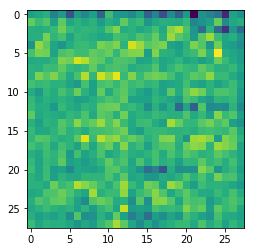

step:3100 D_l:0.424477 G_l:3.200687


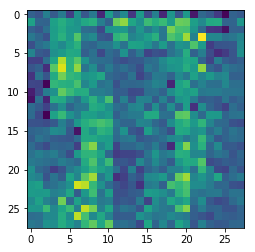

step:3200 D_l:0.283585 G_l:2.766678


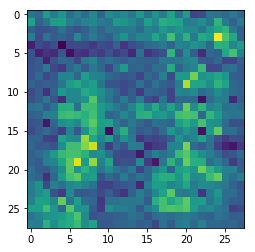

step:3300 D_l:0.383380 G_l:2.878220


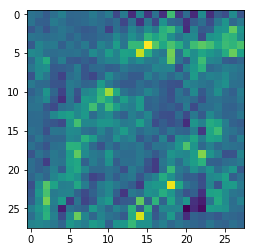

step:3400 D_l:0.340021 G_l:2.389975


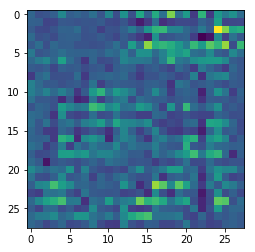

step:3500 D_l:0.391716 G_l:3.228394


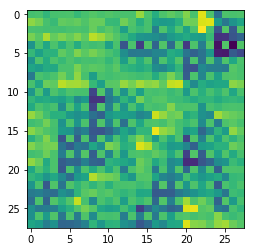

step:3600 D_l:0.271383 G_l:1.987428


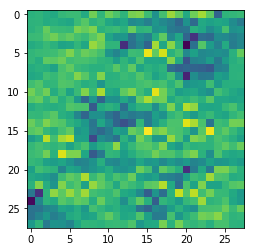

step:3700 D_l:0.137826 G_l:4.094217


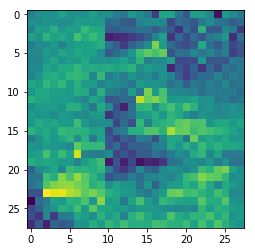

step:3800 D_l:0.147867 G_l:3.299705


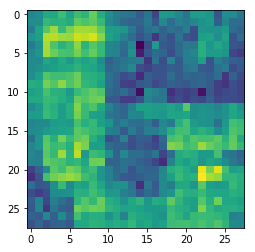

step:3900 D_l:0.195717 G_l:5.018337


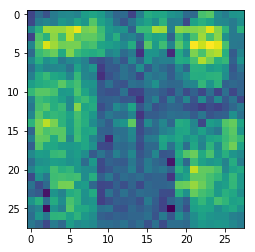

step:4000 D_l:0.027176 G_l:4.304604


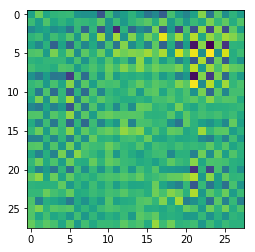

step:4100 D_l:0.157595 G_l:3.595725


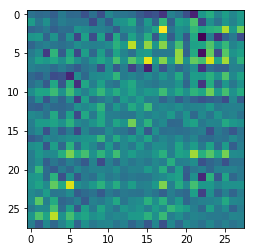

step:4200 D_l:0.094288 G_l:3.851321


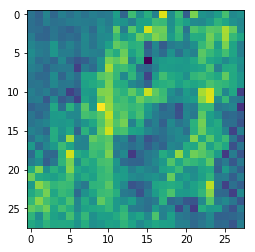

step:4300 D_l:0.168559 G_l:3.174068


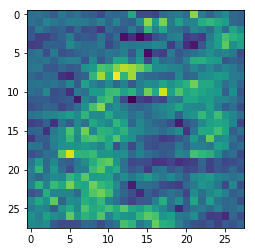

step:4400 D_l:0.363757 G_l:2.378737


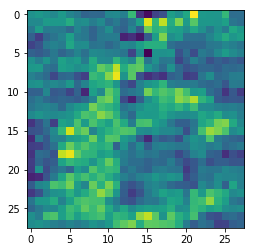

step:4500 D_l:0.449008 G_l:2.216998


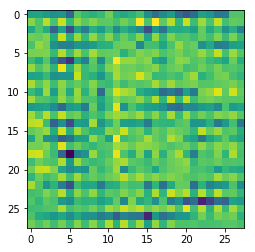

step:4600 D_l:0.299925 G_l:3.098988


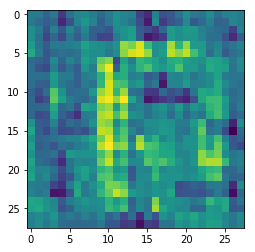

step:4700 D_l:0.249695 G_l:2.589274


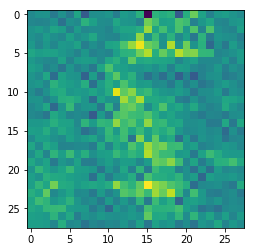

step:4800 D_l:0.275557 G_l:2.803590


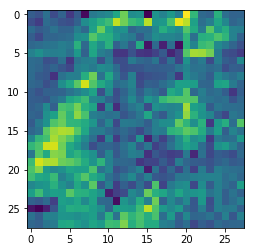

step:4900 D_l:0.865426 G_l:1.332539


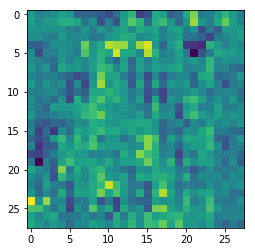

step:5000 D_l:0.130916 G_l:3.094592


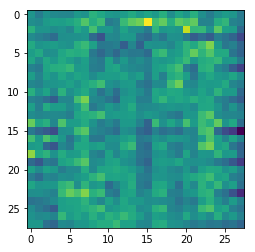

step:5100 D_l:0.249557 G_l:4.656851


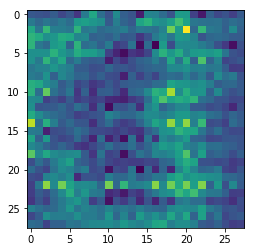

step:5200 D_l:0.247496 G_l:2.612022


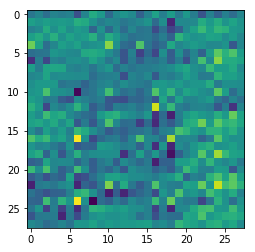

step:5300 D_l:0.535476 G_l:1.867918


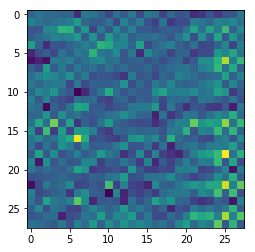

step:5400 D_l:0.322248 G_l:3.065015


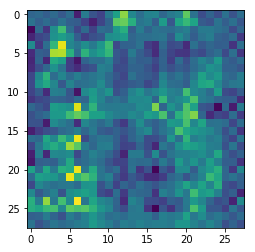

step:5500 D_l:0.324312 G_l:2.958202


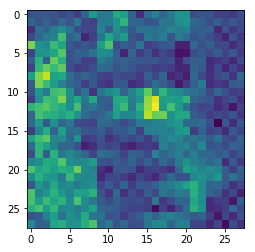

step:5600 D_l:0.464567 G_l:2.555998


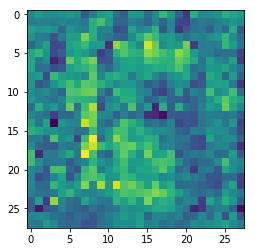

step:5700 D_l:0.092273 G_l:3.588945


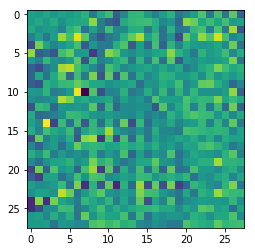

step:5800 D_l:0.422470 G_l:2.371086


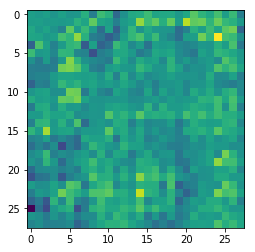

step:5900 D_l:0.024633 G_l:4.329864


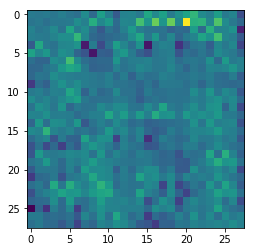

step:6000 D_l:0.928462 G_l:3.408866


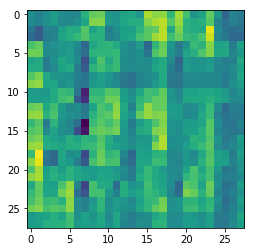

step:6100 D_l:0.221832 G_l:3.237829


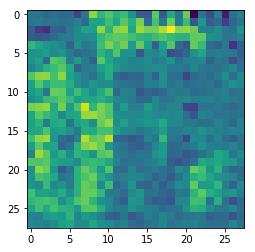

step:6200 D_l:0.145286 G_l:4.076743


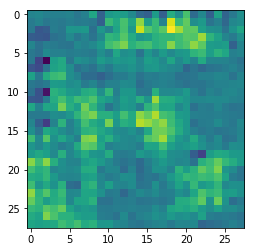

step:6300 D_l:0.221581 G_l:2.419436


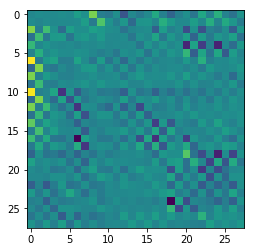

step:6400 D_l:0.068180 G_l:4.896546


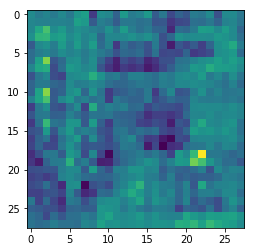

step:6500 D_l:0.406719 G_l:4.749049


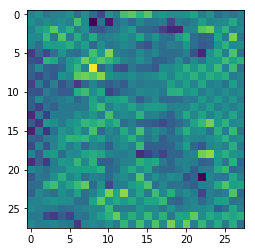

step:6600 D_l:0.023823 G_l:4.046294


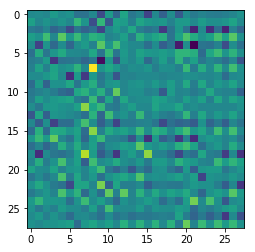

step:6700 D_l:0.040162 G_l:4.007152


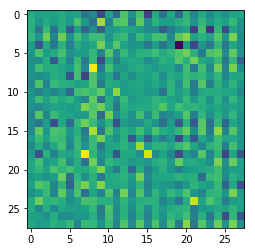

step:6800 D_l:0.190816 G_l:3.322887


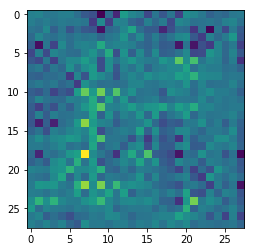

step:6900 D_l:0.475683 G_l:1.535143


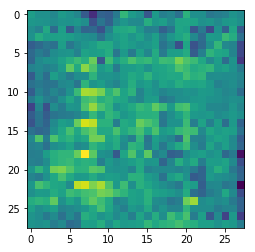

step:7000 D_l:0.020540 G_l:4.908102


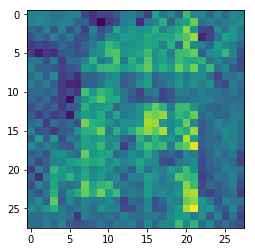

step:7100 D_l:0.811038 G_l:2.562129


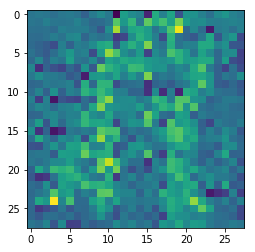

step:7200 D_l:0.178404 G_l:3.463204


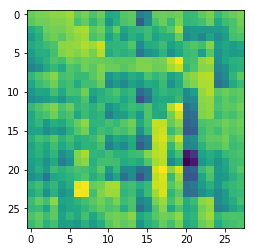

step:7300 D_l:0.100818 G_l:7.487872


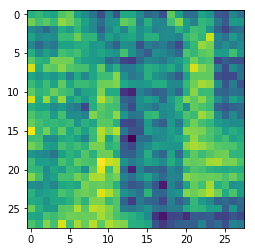

step:7400 D_l:1.475348 G_l:4.594225


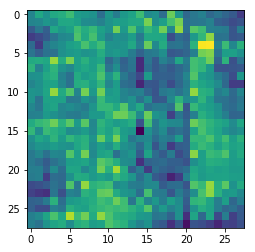

step:7500 D_l:0.579222 G_l:3.907512


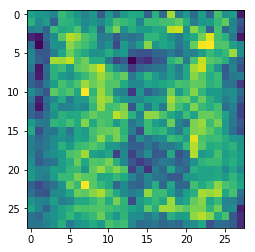

step:7600 D_l:0.054739 G_l:3.751072


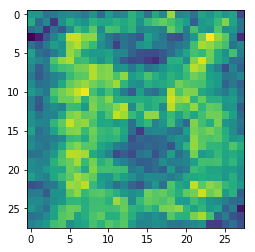

step:7700 D_l:0.240650 G_l:2.955185


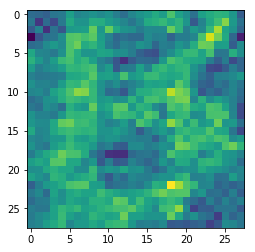

step:7800 D_l:0.067852 G_l:4.033701


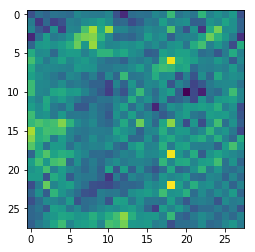

step:7900 D_l:0.093449 G_l:3.952168


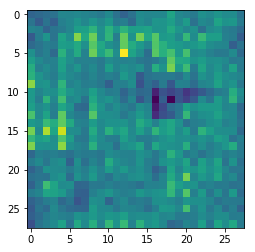

step:8000 D_l:0.355962 G_l:2.140329


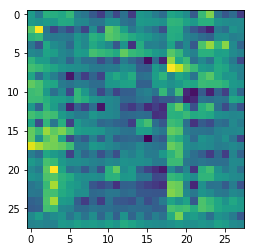

step:8100 D_l:0.151581 G_l:3.045835


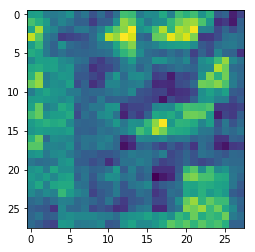

step:8200 D_l:0.104505 G_l:3.852676


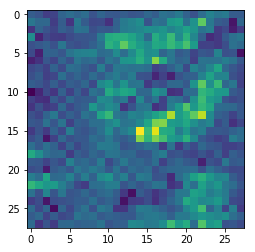

step:8300 D_l:0.384622 G_l:12.691675


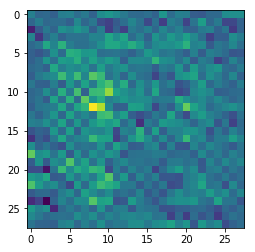

step:8400 D_l:0.318453 G_l:3.427112


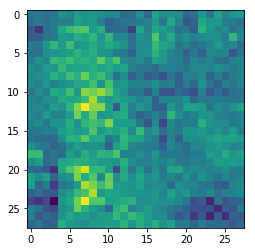

step:8500 D_l:0.267620 G_l:2.927444


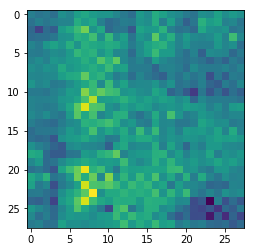

step:8600 D_l:0.328455 G_l:7.090724


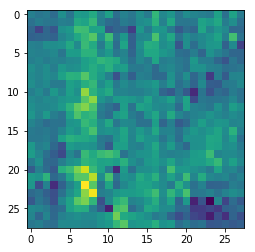

step:8700 D_l:0.120139 G_l:4.099918


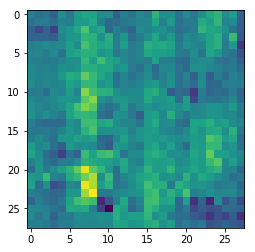

step:8800 D_l:0.263091 G_l:2.857800


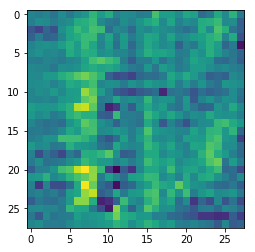

step:8900 D_l:0.180959 G_l:3.906577


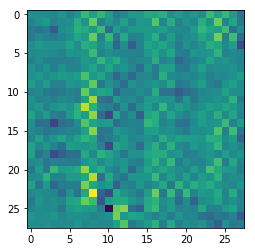

step:9000 D_l:0.054940 G_l:3.768671


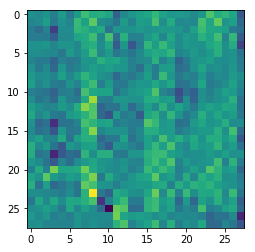

step:9100 D_l:0.192547 G_l:6.105022


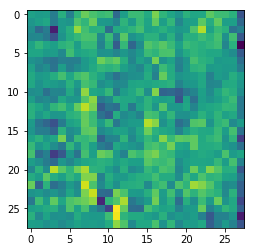

step:9200 D_l:0.029364 G_l:3.923497


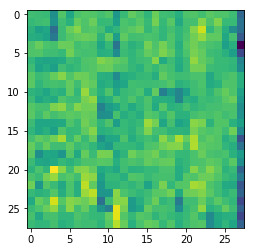

step:9300 D_l:0.080744 G_l:3.186173


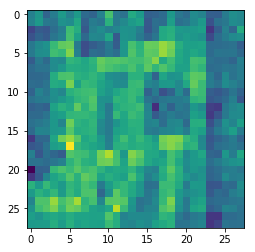

step:9400 D_l:0.144429 G_l:4.660964


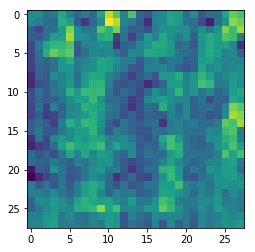

step:9500 D_l:0.010437 G_l:6.529071


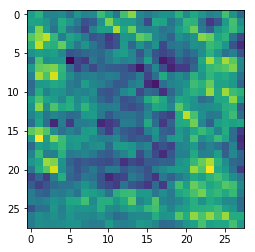

step:9600 D_l:0.448278 G_l:3.169272


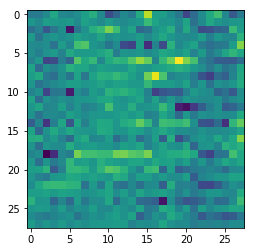

step:9700 D_l:0.045236 G_l:4.503380


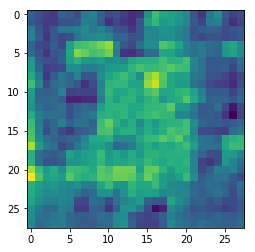

step:9800 D_l:0.024240 G_l:4.067467


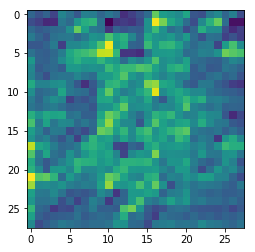

step:9900 D_l:0.326719 G_l:3.597389


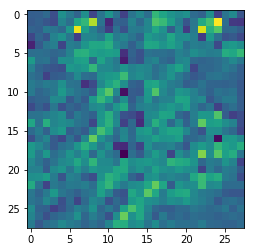

step:10000 D_l:0.025853 G_l:4.206974


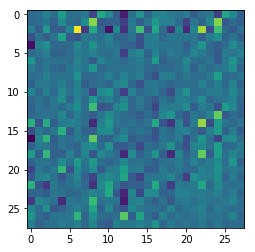

step:10100 D_l:0.204879 G_l:2.503707


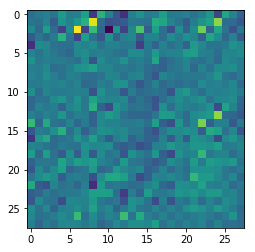

step:10200 D_l:0.178788 G_l:2.940672


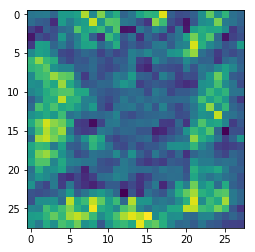

step:10300 D_l:0.018996 G_l:5.556482


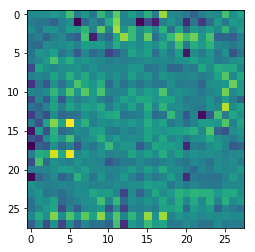

step:10400 D_l:0.139268 G_l:3.249974


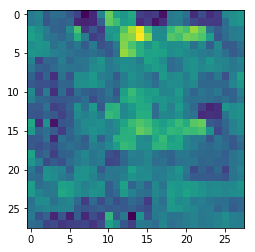

step:10500 D_l:0.109722 G_l:3.704237


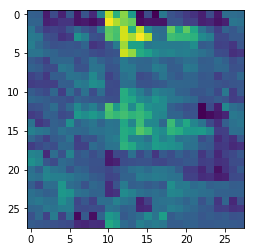

step:10600 D_l:0.297674 G_l:3.161024


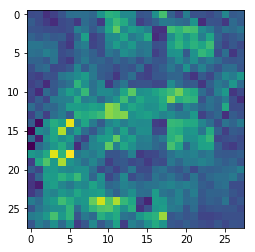

step:10700 D_l:0.004137 G_l:5.604502


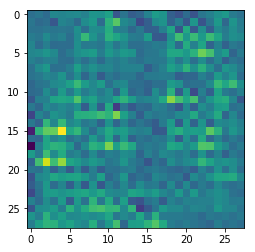

step:10800 D_l:0.025035 G_l:3.879267


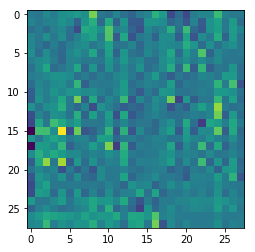

step:10900 D_l:0.157897 G_l:3.938887


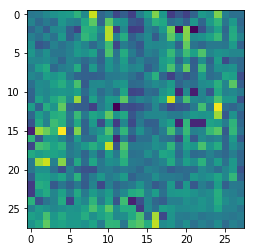

step:11000 D_l:0.152774 G_l:3.746156


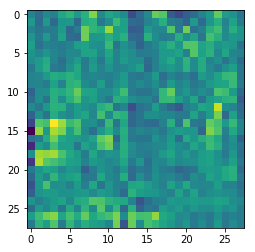

step:11100 D_l:0.053654 G_l:4.091085


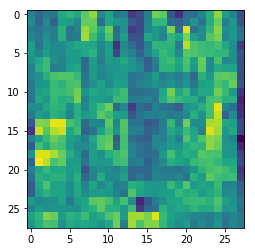

step:11200 D_l:0.253692 G_l:3.144637


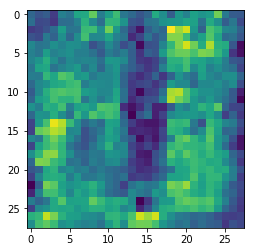

step:11300 D_l:0.259111 G_l:2.941194


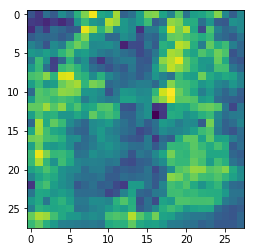

step:11400 D_l:0.348799 G_l:2.816949


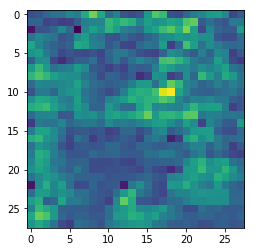

step:11500 D_l:0.054141 G_l:3.356812


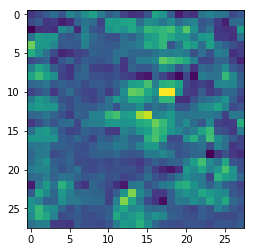

step:11600 D_l:0.121059 G_l:3.325984


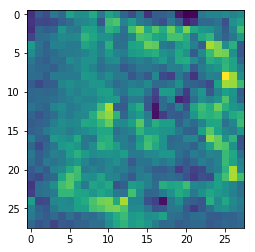

step:11700 D_l:0.826151 G_l:2.696223


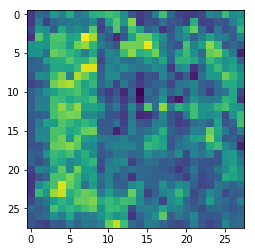

step:11800 D_l:0.269278 G_l:3.943563


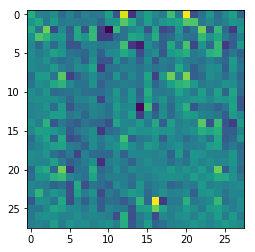

step:11900 D_l:0.019505 G_l:4.378378


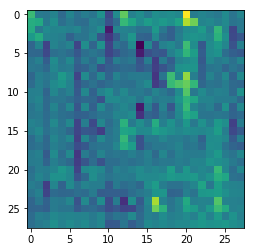

step:12000 D_l:0.066580 G_l:4.910791


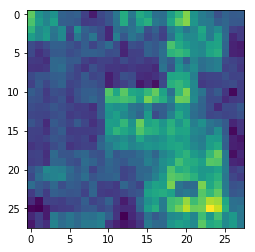

step:12100 D_l:0.037554 G_l:3.831583


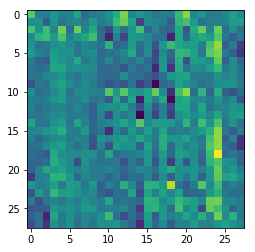

step:12200 D_l:0.023363 G_l:3.980252


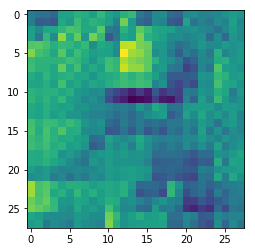

step:12300 D_l:0.135001 G_l:3.895246


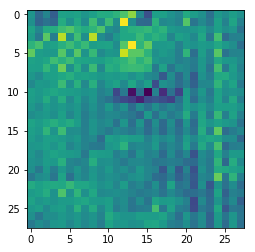

step:12400 D_l:0.141510 G_l:3.748568


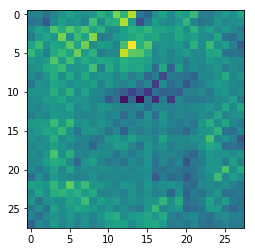

step:12500 D_l:0.297756 G_l:3.975170


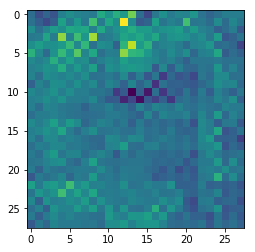

step:12600 D_l:0.019027 G_l:4.267310


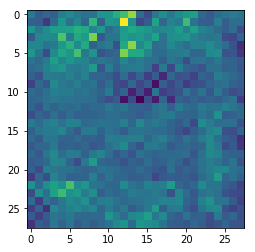

step:12700 D_l:0.059157 G_l:4.254792


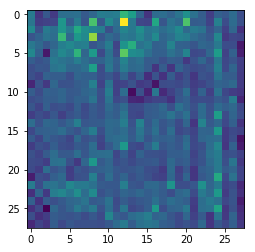

step:12800 D_l:0.019518 G_l:4.282684


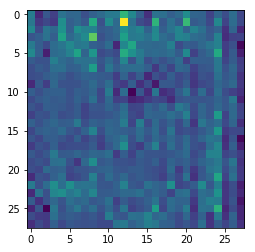

step:12900 D_l:0.153417 G_l:4.254920


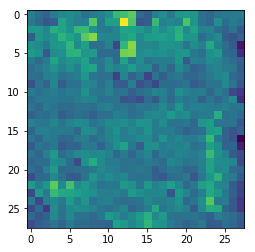

step:13000 D_l:0.028188 G_l:3.986768


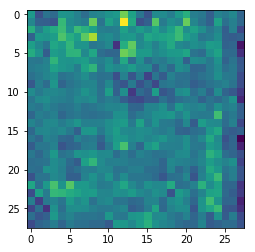

step:13100 D_l:0.015472 G_l:4.351204


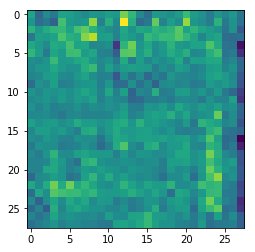

KeyboardInterrupt: 

In [11]:
num_steps = 100001

real_data_batcher = data_batcher(data, batch_size//2, loop_around=True)

with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as session:
    
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()

    print('Initialized.')
    
    for step in tqdm(range(num_steps)):
        
        # -- D step --
        
        for i in range(1):
            feed_dict = {
                tf_real_data: next(real_data_batcher)
            }

            _, D_l, P_R, P_F = session.run([D_optimizer, D_loss, D_prediction_on_real_data, D_prediction_on_fake_data], feed_dict=feed_dict)

        
        #plt.imshow(imgs[0].reshape(28, 28))
        #plt.show()
        
        #plt.imshow(imgs[-1].reshape(28, 28))
        #plt.show()

        
        # ------------
        
        
        
        
        # -- G step --
        
        for i in range(1):
            _, G_l, G_images = session.run([G_optimizer, G_loss, gen_images], feed_dict=feed_dict)
        
        # ------------
        
        
        if step % 100 == 0:
            #print(P_R.reshape(-1))
            #print(P_F.reshape(-1))
        
            print('step:{} D_l:{:.6f} G_l:{:.6f}'.format(step, D_l, G_l))
            plt.imshow(G_images[0].reshape((28, 28)))
            plt.show()